In [1]:
import numpy as np
import tensorflow as tf
from utility import *
import matplotlib.pyplot as plt
from matplotlib import colors
import os
%load_ext autoreload
%autoreload 2
%pylab inline

/home/bzr0014/anaconda3/envs/tensorCpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorCpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
halfSize=9
fullSize = 2*halfSize+1
X_orig, y_orig, cache = loadData(halfSize=halfSize, root="./", log_convert=False)
X_orig = np.array(X_orig).reshape(-1, fullSize, fullSize, 1)
y_orig = np.array(y_orig)

Starting to load data...
Cropping to mininmum size ...
n = 495 ; m = 495
Cropping to mininmum size ...
n = 486 ; m = 486
Cropping to mininmum size ...
n = 396 ; m = 396
Cropping to mininmum size ...
n = 383 ; m = 383
Cropping to mininmum size ...
n = 362 ; m = 362
Cropping to mininmum size ...
n = 342 ; m = 342
Cropping to mininmum size ...
n = 318 ; m = 318
Cropping to mininmum size ...
n = 293 ; m = 293
Cropping to mininmum size ...
n = 281 ; m = 281
Cropping to mininmum size ...
n = 271 ; m = 271
Cropping to mininmum size ...
n = 269 ; m = 269
Cropping to mininmum size ...
n = 265 ; m = 265
Cropping to mininmum size ...
n = 229 ; m = 229
Cropping to mininmum size ...
n = 213 ; m = 213
Cropping to mininmum size ...
n = 201 ; m = 201
Cropping to mininmum size ...
n = 178 ; m = 178
Cropping to mininmum size ...
n = 158 ; m = 158
Cropping to mininmum size ...
n = 153 ; m = 153
Cropping to mininmum size ...
n = 119 ; m = 119
Cropping to mininmum size ...
n = 125 ; m = 125
Cropping to min

In [12]:
myCache, nss_low, nss_high = cache
indices = []
sum = 0
for i in range(1, 24):
    n1 = nss_low[i, 1]
    n2 = nss_high[i, 1]
    n = np.min([n1, n2])
    sum += (n - 2*halfSize) **2
    indices.append(sum)
    print("chromosome %2d -> %d"%(i, sum))

chromosome  1 -> 227529
chromosome  2 -> 446553
chromosome  3 -> 589437
chromosome  4 -> 722662
chromosome  5 -> 840998
chromosome  6 -> 945974
chromosome  7 -> 1035974
chromosome  8 -> 1111599
chromosome  9 -> 1180768
chromosome 10 -> 1244777
chromosome 11 -> 1307778
chromosome 12 -> 1368787
chromosome 13 -> 1413308
chromosome 14 -> 1451333
chromosome 15 -> 1484822
chromosome 16 -> 1510422
chromosome 17 -> 1530022
chromosome 18 -> 1548247
chromosome 19 -> 1558448
chromosome 20 -> 1569897
chromosome 21 -> 1575673
chromosome 22 -> 1582397
chromosome 23 -> 1667661


In [4]:
print(X_orig.shape)
y_total = np.log(y_orig+1)
y_total = (y_total - y_total.mean()) / y_total.std()
totalSize = indices[4]
trainSize = indices[3] #up until chromosome 
X_total = X_orig[:totalSize]
y_total = y_total[:totalSize]
X_train = X_total[:trainSize]
y_train = y_total[:trainSize]
X_val = X_total[trainSize:]
y_val = y_total[trainSize:]
print(X_total.shape)
print(X_train.shape)
print(y_train.shape)
print(np.min(y_total))
print(np.max(y_total))

(1667661, 19, 19, 1)
(824822, 19, 19, 1)
(709222, 19, 19, 1)
(709222,)
-2.59822577286801
3.5287422786862255


In [14]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, fullSize, fullSize, 1])
y = tf.placeholder(tf.float32, [None])
is_training = tf.placeholder(tf.bool)

def myModel(X, y):
    Wconv1 = tf.get_variable("Wconv1", shape=[3, 3, 1, 23])
    bconv1 = tf.get_variable("bconv1", shape=[23])
    Wconv2 = tf.get_variable("Wconv2", shape=[3, 3, 23, 23])
    bconv2 = tf.get_variable("bconv2", shape=[23])
    W1 = tf.get_variable("W1", shape=[(fullSize-4) * (fullSize-4) * 23, 10])
    b1 = tf.get_variable("b1", shape=[10])
    W2 = tf.get_variable("W2", shape=[10, 1])
    b2 = tf.get_variable("b2", shape=[1])
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding="VALID") + bconv1
    h1 = tf.nn.relu(a1)
    a2 = tf.nn.conv2d(h1, Wconv2, strides=[1, 1, 1, 1], padding="VALID") + bconv2
    h2 = tf.nn.relu(a2)
    h2_flat = tf.reshape(h2, [-1, (fullSize-4) * (fullSize-4) * 23])
    h3 = tf.matmul(h2_flat, W1) + b1
    y_out = tf.matmul(h3, W2) + b2
    return y_out

y_out = myModel(X, y)

diff = y - y_out
mean_loss = tf.reduce_mean(tf.pow(y_out - y,2))

optimizer = tf.train.AdamOptimizer(5e-3)
train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 10.3
Iteration 100: with minibatch training loss = 1.02
Iteration 200: with minibatch training loss = 0.933
Iteration 300: with minibatch training loss = 0.775
Iteration 400: with minibatch training loss = 0.869
Iteration 500: with minibatch training loss = 0.833
Iteration 600: with minibatch training loss = 0.932
Iteration 700: with minibatch training loss = 0.825
Epoch 1, Overall loss = 4.86


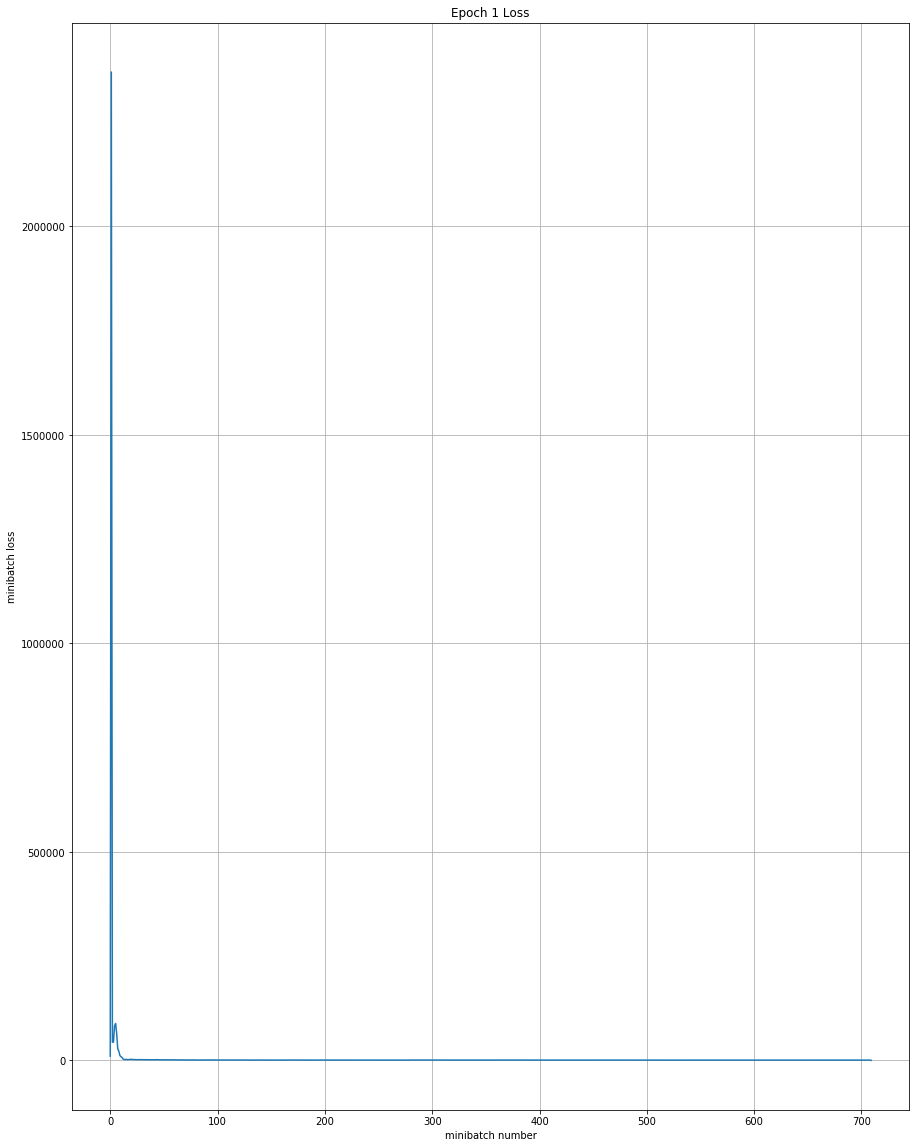

Validation
Epoch 1, Overall loss = 0.654


In [15]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=2, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, predict]
    if training_now:
        variables[-1] = training
    # counter 
    iter_cnt = 0
    predictedYs = []
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, yOut = session.run(variables,feed_dict=feed_dict)
            predictedYs.append(yOut)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(total_loss,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss, predictedYs

with tf.Session() as sess:
    with tf.device("/cpu:0"):
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train, epochs=1, batch_size=1000, print_every=100, \
                  training=train_step,plot_losses=True)
        print('Validation')
        total_loss, predictedYs = run_model(sess,y_out, mean_loss, X_val, y_val, 1, 100)

In [16]:
predictedYsArray = np.array(predictedYs).reshape(-1)
print(predictedYsArray.shape)
print(totalSize - trainSize)

(115600,)
115600


chromosome 4 and chromosome 4
Number of rows and columns: 1, 3


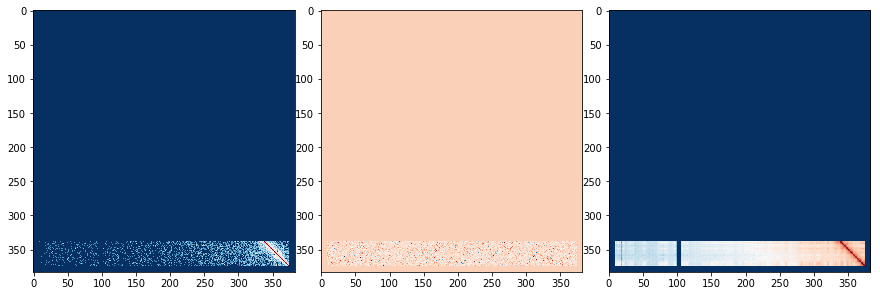

chromosome 5 and chromosome 5
Number of rows and columns: 1, 3


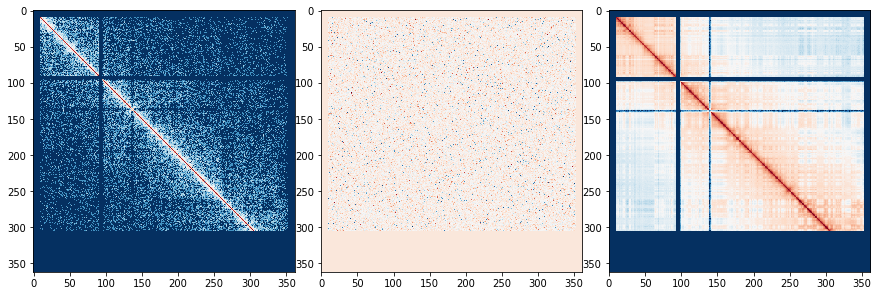

In [17]:
pylab.rcParams['figure.figsize'] = (15, 20)
reconstructed1 = reconstructFromPredictions(X_val, predictedYsArray, cache, beg=trainSize, end=totalSize)
reconstructed2 = reconstructFromPredictions(X_val, y_orig[trainSize:totalSize], cache, beg=trainSize, end=totalSize)
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        images1 = reconstructed1.get((chr1, chr2), None)
        images2 = reconstructed2.get((chr1, chr2), None)
        if images1 == None:
            continue
        print("chromosome %d and chromosome %d"%(chr1, chr2))
        images = [images1[0], images1[1], images2[1]]
        showImages(images)

In [25]:
result = predictedYsArray - y_orig[trainSize:totalSize]
np.mean(result * result)

176668804.36254102

In [2]:
a = tf.sparse_placeholder(tf.float64)
b = tf.placeholder(tf.float64)

ao = scipy.sparse.rand(3, 10000, density=.4)
tf_ao = tf.SparseTensorValue(
    indices=np.array([ao.row, ao.col]).T,
    values=ao.data,
    dense_shape=ao.shape)
bo = np.random.rand(10000, 5)

c = tf.sparse_tensor_dense_matmul(a, b)

feed_dict = {a: tf_ao, b: bo}

with tf.Session() as sess:
    with tf.device("/cpu:0"):
        out = sess.run(c, feed_dict=feed_dict)
        print("\n")
        print(ao.dot(bo))

print(out)



[[ 987.06790687  972.15904415  988.38238443  981.06707546 1008.42496127]
 [ 991.28383759 1017.48437671 1006.60917523 1006.88259052 1026.94421663]
 [ 984.95881262  976.47707223  999.29465081  986.75494814 1023.28645221]]
[[ 987.06790687  972.15904415  988.38238443  981.06707546 1008.42496127]
 [ 991.28383759 1017.48437671 1006.60917523 1006.88259052 1026.94421663]
 [ 984.95881262  976.47707223  999.29465081  986.75494814 1023.28645221]]
